# Market Data Simulator

Do you ever need some market data tp try something out?  I do quite often.  About half the time I go to one of the marketplaces for data that are becoming super-super-useful in this regard, and about half the time I'll craft some data to fit the purpose.  This notebook crafts market data with a configurable look-and-feel for a given time range.  Therein lies the intent of the notebook, in this case I want data that looks and feels like FX market data and, in the first instance, I don't care about the properties of the data as much as I care about having a reasonable frequency of ticks for a given time range.

The end result is data that looks fine when plotted, is fine to analyze and quick to produce (6 months data in ~45 seconds).

Feel free to have fun...

In [3]:
import random
import datetime
import pandas as pd

In [1]:
import base64
from collections import OrderedDict
import json
import requests


class HbaseRestClient(object):
    """ This class provides a simpler interface to using the HBase REST
    API. It includes some common needs such as base64 encoding/decoding
    and assembling values into the appropriate data structures.
    """

    def __init__(self, base_url, table_name):
        """ Creates an instance of an Hbase REST client.
        :param base_url: The hostname and port of the Hbase REST server.
        e.g 'http://130.211.170.242:8080'
        :param table_name: The name of the table
        :return:
        """
        assert (len(table_name) > 0)
        self.base_url = base_url
        self.table_name = table_name

    def put_row(self, row_key, column, value):
        """ Puts a value into an HBase cell via REST
        This puts a value in the fully qualified column name. This assumes
        that the table has already been created with the column family in its
        schema. If it doesn't exist, you can use create_table() to doso.
        :param row_key: The row we want to put a value into.
        :param column: The fully qualified column (e.g.
        my_column_family:content)
        :param value: A string representing the sequence of bytes we want to
        put into the cell
        :return: None
        """
        row_key_encoded = base64.b64encode(row_key)
        column_encoded = base64.b64encode(column)
        value_encoded = base64.b64encode(value)

        cell = OrderedDict([
            ("key", row_key_encoded),
            ("Cell", [{"column": column_encoded, "$": value_encoded}])
        ])
        rows = [cell]
        json_output = {"Row": rows}
        r = requests.post(self.base_url + "/" + self.table_name + "/" + row_key,
                          data=json.dumps(json_output),
                          headers={
                              "Content-Type": "application/json",
                              "Accept": "application/json",
                          }
                          )
        if r.status_code != 200:
            print "got status code %d when putting" % r.status_code

    def get_row(self, row_key):
        """ Returns a value from the first column in a row.
        :param row_key: The row to return the value from
        :return: The bytes in the cell represented as a Python string.
        """
        request = requests.get(self.base_url + "/" + self.table_name + "/" +
                               row_key,
                               headers={"Accept": "application/json"})
        if request.status_code != 200:
            return None
        text = json.loads(request.text)
        value = base64.b64decode(text['Row'][0]['Cell'][0]['$'])
        return value

    def delete(self, row_key):
        """ Deletes a row
        :param row_key: The row key of the row to delete
        :return: None
        """
        requests.delete(self.base_url + "/" + self.table_name + "/" + row_key)

    def create_table(self, table_name, column_family):
        """ Creates a table with a single column family.
        It's safe to call if the table already exists, it will just fail
        silently.
        :param table_name: The name of the
        :param column_family: The column family to create the table with.
        :return: None
        """
        json_output = {"name": table_name,
                       "ColumnSchema": [{"name": column_family}]}
        requests.post(self.base_url + '/' + table_name + '/schema',
                      data=json.dumps(json_output),
                      headers={
                          "Content-Type": "application/json",
                          "Accept": "application/json"
                      })

    def get_tables(self):
        """ Returns a list of the tables in Hbase
        :return: A list of the table names as strings
        """
        r = requests.get(self.base_url)
        tables = r.text.split('\n')
        return tables

In [4]:
# Starting point for the mid price.
STARTING_MID = 150.0

# Minimum value for the mid price.  
# N.B. If the random movement of the mid price falls below this minimum 
# we'll reset it to the minimum which will effectively make it bounce 
# off the minimum.
MIN_MID = 50.0

# Starting point for the spread.
STARTING_SPREAD = 2.0

# Minimum and maximum values for the spread.
# N.B. If the random movement of the spread passes the minimum or maximum
# we'll resent to the appropriate value which will effectively make it bounce
# off these boundaries.
MIN_SPREAD = 0.1
# Maximum spread should be greater than STARTING_SPREAD
MAX_SPREAD = 3.0

TIME_FORMAT = '%m/%d/%y %H:%M:%S.%f'

# Start and end time.
START_TIME = '1/1/15 00:00:00.000'
FINISH_TIME = '1/2/15 00:00:00.000'

# Time deltas.  At each point we'll choose a delta from this list.
# I chose this style of randomization to control the frequency of the ticks such 
# that the data looks more EBS or Reuters style than it does Currenex style.
# This style makes manipulation/analysis somewhat easier.
TIME_DELTAS = [
  datetime.timedelta(milliseconds=1000), 
  datetime.timedelta(milliseconds=2000), 
  datetime.timedelta(milliseconds=4000), 
  datetime.timedelta(milliseconds=6000), 
  datetime.timedelta(milliseconds=8000), 
  datetime.timedelta(milliseconds=10000)]

In [5]:
start_datetime = datetime.datetime.strptime(START_TIME, TIME_FORMAT)
finish_datetime = datetime.datetime.strptime(FINISH_TIME, TIME_FORMAT)

current_mid = STARTING_MID
current_spread = STARTING_SPREAD

# The bid and ask are calculated from the spread, equidistant from the mid with bid lower than ask.
current_bid = current_mid - (current_spread/2)
current_ask = current_mid + (current_spread/2)

current_datetime = start_datetime

market_data = pd.DataFrame(columns=['datetime', 'mid', 'spread', 'bid', 'ask'])

# Using a list of rows (that get appended to the dataframe at the end) because it's much faster than appending each time.
rows_list = []
rows_list.append(
  {'datetime': current_datetime,
   'mid': current_mid,
   'spread': current_spread,
   'bid': current_bid,
   'ask': current_ask
  }
)

while True:
  
  # Choose a random time increment from the list of deltas.
  time_delta = random.choice(TIME_DELTAS)
  current_datetime = current_datetime + time_delta
  
  # If the incremented datetime is beyond the finish datetime break out of the loop
  if current_datetime > finish_datetime:
    break
  
  # Choose a random change to the mid.
  mid_delta = random.normalvariate(0, 0.1)
  current_mid = current_mid + mid_delta
  
  # Reset the mid to the minimum if necessary.
  if current_mid < MIN_MID:
    current_mid = MIN_MID
  
  # Choose a random change to the spread.
  spread_delta = random.normalvariate(0, 0.1)
  current_spread = current_spread + spread_delta
  
  # Reset the spread to the min/max if necessary.
  if current_spread < MIN_SPREAD:
    current_spread = MIN_SPREAD
  if current_spread > MAX_SPREAD:
    current_spread = MAX_SPREAD
  
  current_bid = current_mid - (current_spread/2)
  current_ask = current_mid + (current_spread/2)
  
  rows_list.append(
    {'datetime': current_datetime,
     'mid': current_mid,
     'spread': current_spread,
     'bid': current_bid,
     'ask': current_ask
    }
  )
  
# Append all rows to the dataframe and set the index at the datetime.
market_data = market_data.append(rows_list)
market_data = market_data.set_index('datetime')

Let's plot the bid and ask to check things look market data-ey...  Yep, market data-ey...

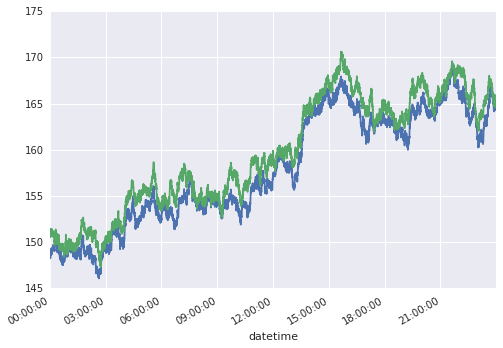

In [6]:
market_data.bid.plot()
market_data.ask.plot()

The purpose of printing out the final five entries in the data is to allow continutity of a sort.  For example, if you'd like to create market data for January, then for February, you can alter the starting values for the February run to match the ending values for the January run.  This level of automation is fine for my needs here...

In [8]:
market_data[:-5:-1]

,mid,spread,bid,ask
datetime,,,,
2015-01-01 23:59:57,164.695670,0.360265,164.515537,164.875803
2015-01-01 23:59:51,164.601144,0.370622,164.415833,164.786455
2015-01-01 23:59:43,164.607302,0.365847,164.424379,164.790226
2015-01-01 23:59:35,164.663666,0.157961,164.584686,164.742647


In [15]:
client = HbaseRestClient('http://130.211.143.156:8080', 'ts1')

In [12]:
client.get_tables()

[u'some-table2', u'']

In [14]:
print client.create_table('ts1', 'data')

None


In [16]:
for index, row in market_data.iterrows():
  client.put_row()

2015-01-01 00:00:00 mid       150
spread      2
bid       149
ask       151
Name: 2015-01-01 00:00:00, dtype: float64
2015-01-01 00:00:04 mid       150.009575
spread      1.935606
bid       149.041771
ask       150.977378
Name: 2015-01-01 00:00:04, dtype: float64
2015-01-01 00:00:10 mid       149.939578
spread      2.082825
bid       148.898165
ask       150.980990
Name: 2015-01-01 00:00:10, dtype: float64
2015-01-01 00:00:20 mid       149.736536
spread      2.107206
bid       148.682934
ask       150.790139
Name: 2015-01-01 00:00:20, dtype: float64
2015-01-01 00:00:28 mid       149.592797
spread      2.232535
bid       148.476530
ask       150.709065
Name: 2015-01-01 00:00:28, dtype: float64
2015-01-01 00:00:29 mid       149.685060
spread      2.070509
bid       148.649805
ask       150.720314
Name: 2015-01-01 00:00:29, dtype: float64
2015-01-01 00:00:35 mid       149.766345
spread      1.961853
bid       148.785418
ask       150.747271
Name: 2015-01-01 00:00:35, dtype: float64
2015-0

In [15]:
tmp = market_data.to_csv()

Finally, I'm using a GCS specific command to write the CSV formatted data to a bucket in one of my files in GCP.

In [16]:
#%storage write -v tmp -o gs://bingo-ml-1-market-data/dummy-exchange.csv

In [17]:
print '''Copyright 2015, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at 
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.'''

Copyright 2015, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at 
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
